In [2]:
!pip install tensorflow
!pip show tensorflow
!pip install faiss-gpu

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 10.3 MB/s eta 0:00:00


In [3]:
import torch
import torchvision.models as models
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import faiss

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torchvision import transforms
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **1 часть проекта. Baseline модель (для оценки работы финальной модели)**

Сформируем датасет, состоящий из ссылок на каждое изобрежение в директории на Гугл Диске и данных о жанре каждого изображения альбома.

In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
# Для получения всех файлов в директории и её поддиректориях в Python можно воспользоваться функцией os.walk(). Приведенный ниже код при помощи спискового включения создаст список путей ко всем файлам:
def get_file_paths(directory):
    return [os.path.join(root, filename) for root, _, files in os.walk(directory) for filename in files]

# Функция get_file_paths вернет список, содержащий пути ко всем файлам в заданной директории.
file_paths = get_file_paths('/content/drive/My Drive/Music_genres')
file_paths = pd.DataFrame(file_paths, columns=['picture_address'])
file_paths.head()

,picture_address
0,/content/drive/My Drive/Music_genres/disco/06648dc6-49c4-4902-b9fa-8505b666966a.png
1,/content/drive/My Drive/Music_genres/disco/1fbb654a-e585-4f9c-acc6-97675008c6e7.png
2,/content/drive/My Drive/Music_genres/disco/cf629b5f-3b3f-4710-a531-c7c338e3c991.png
3,/content/drive/My Drive/Music_genres/disco/0e2daa83-849f-3012-8eab-0ef2cc27cdec.png
4,/content/drive/My Drive/Music_genres/disco/99e610b7-40e9-320b-addb-062d08fe866a.png


In [6]:
file_paths['genre'] = 0
file_paths['genre'] = file_paths['picture_address'].str.extract(r'(?<=Music_genres\/)(.+)\/')
file_paths.head()

,picture_address,genre
0,/content/drive/My Drive/Music_genres/disco/06648dc6-49c4-4902-b9fa-8505b666966a.png,disco
1,/content/drive/My Drive/Music_genres/disco/1fbb654a-e585-4f9c-acc6-97675008c6e7.png,disco
2,/content/drive/My Drive/Music_genres/disco/cf629b5f-3b3f-4710-a531-c7c338e3c991.png,disco
3,/content/drive/My Drive/Music_genres/disco/0e2daa83-849f-3012-8eab-0ef2cc27cdec.png,disco
4,/content/drive/My Drive/Music_genres/disco/99e610b7-40e9-320b-addb-062d08fe866a.png,disco


In [7]:
# Загрузка модели:
resnet50_torch = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Убираем последний слой модели, который отвечает за классификацию, при этом  average pooling layer останется.
layers = list(resnet50_torch.children())[:-1]
resnet50 = torch.nn.Sequential(*(list(resnet50_torch.children())[:-1]))

# Перевод модели в режим оценки:
resnet50_torch.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

С помощью цикла for пропускаем каждое изображение через нормализацию, а потом через урезанную модель resnet50 для извлечения эмбендингов:

In [ ]:
%%time
tensor_frame = pd.DataFrame() #создаем новый пустой датасет tensor_frame

for address in file_paths['picture_address']:
    # предобработка и открытие изображений (размер каждого уже 224x224)
    image_path = str(address)
    img = Image.open(image_path).convert("RGB")

    # преобразование изображения, нормализация
    preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    img_tensor = preprocess(img).unsqueeze(0)   # Он указывает позицию, в которой следует добавить размер. torch.unsqueeze добавляет тензору дополнительное измерение.

    with torch.no_grad():
        # пропускаем изображение через урезанную модель. no_grad - без вычисоления градиентов.
        img_features = resnet50(img_tensor)

# example
# 3 channels, 32 width, 32 height and some 1 unnecessary dimensions
# tensor = torch.randn(3, 1, 32, 1, 32, 1)
# 1 batch, 3 channels, 32 width, 32 height again
# tensor.squeeze().unsqueeze(0) # [1, 3, 32, 32]
# Проще говоря, unsqueeze() «добавляет» поверхностное измерение 1 к тензору (в указанном измерении), а сжатие удаляет все поверхностные измерения 1 из тензора.
#print(img_features.squeeze().numpy())
#print(type(img_features.squeeze().numpy()))

    tensor_frame[address] = pd.DataFrame(img_features.squeeze())

формирование датасета из полученных тензоров:

In [ ]:
tensor_frame = tensor_frame.T # транспонированный датафрейм

tensor_frame['genre'] = 0
tensor_frame = tensor_frame.reset_index()
tensor_frame['genre'] = tensor_frame['index'].str.extract(r'(?<=Music_genres\/)(.+)\/') # добавление в датасет векторов-тензоров столбца с жанром изображения
del tensor_frame['index']
tensor_frame.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,genre
0,0.230328,2.404709,0.496343,0.261224,0.736051,0.300651,0.182449,0.430450,0.264732,0.081668,...,0.383825,0.712712,0.082662,0.064467,0.207496,0.586465,0.125519,0.091353,0.297273,disco
1,0.261614,1.388774,0.895370,0.435750,0.630487,0.359392,0.287820,0.421424,0.286478,0.244829,...,0.126911,0.588590,0.111098,0.040453,0.266989,0.241352,0.146605,0.279127,0.433660,disco
2,0.517831,1.168180,0.330986,0.327988,0.515467,0.366332,0.189560,0.165811,1.074460,0.470437,...,0.170520,0.375020,1.082666,0.489346,0.206567,0.165637,0.287761,0.504138,0.301553,disco
3,0.453949,2.405547,2.224967,0.309922,0.986348,0.041251,0.141286,0.048897,0.310324,0.936568,...,0.121693,0.260474,0.290525,1.136570,0.312640,0.406044,0.233157,0.318620,0.595171,disco
4,0.173815,2.494324,0.925782,0.211215,0.708465,0.459731,0.247822,0.274053,0.078577,0.286032,...,0.052163,0.383810,0.122527,0.575661,0.299794,0.546993,0.060966,0.256871,0.131710,disco
5,0.138642,0.646773,0.475105,0.165702,0.942156,0.122567,0.158862,0.040832,0.157344,0.552793,...,0.133636,0.481339,0.161639,0.692633,0.104706,0.194040,0.104919,0.233155,0.046494,disco
6,0.082737,0.934516,1.187213,0.071367,1.517430,0.056463,0.119465,0.340933,0.261738,0.410646,...,0.129924,0.404549,0.382546,1.567537,0.390115,0.445153,0.379178,0.584431,0.305518,disco
7,0.134860,3.865466,0.408257,0.109196,0.380647,0.425460,0.691525,0.121401,0.266167,0.756402,...,0.360886,0.619544,0.467810,0.360407,0.252201,0.266807,0.166913,0.439367,0.153527,disco
8,0.146278,2.106908,0.650663,0.076839,0.619625,0.180239,0.097969,0.087631,0.518376,0.139627,...,0.171677,0.656560,0.146953,0.351931,0.191307,0.271755,0.224886,0.283155,0.015385,disco
9,0.281927,1.943066,0.513739,0.266424,0.720323,0.019893,0.343551,0.496469,0.181647,0.669245,...,0.241408,0.387310,0.141274,0.379782,0.064368,0.592786,0.138105,0.381707,0.398591,disco


Сохрание полученного датасета на Гугл Диск:

In [ ]:
tensor_frame.to_csv('tensors_dataset_2.csv')
!cp tensors_dataset_2.csv "drive/My Drive/"

In [8]:
data =pd.read_csv('/content/drive/My Drive/tensors_dataset_2.csv')# чтение файла с данными и сохранение в data
del data['Unnamed: 0']
data.head()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,genre
0,0.230328,2.404709,0.496343,0.261224,0.736051,0.300651,0.182449,0.430450,0.264732,0.081668,...,0.383825,0.712712,0.082662,0.064467,0.207496,0.586465,0.125519,0.091353,0.297273,disco
1,0.261614,1.388774,0.895370,0.435750,0.630487,0.359391,0.287820,0.421424,0.286478,0.244829,...,0.126911,0.588590,0.111098,0.040453,0.266989,0.241352,0.146605,0.279127,0.433660,disco
2,0.517831,1.168180,0.330986,0.327988,0.515467,0.366332,0.189560,0.165811,1.074460,0.470437,...,0.170520,0.375020,1.082666,0.489346,0.206567,0.165637,0.287761,0.504138,0.301553,disco
3,0.453949,2.405547,2.224967,0.309922,0.986348,0.041251,0.141286,0.048897,0.310324,0.936568,...,0.121693,0.260474,0.290525,1.136570,0.312640,0.406044,0.233157,0.318620,0.595171,disco
4,0.173815,2.494324,0.925782,0.211215,0.708465,0.459731,0.247822,0.274053,0.078577,0.286032,...,0.052163,0.383810,0.122527,0.575661,0.299794,0.546993,0.060966,0.256871,0.131710,disco


Разделение данных на выборки для запуска и проверки Baseline модели:

In [9]:
TEST_SIZE = 0.20
RANDOM_STATE = 123456

In [10]:
# Разделение датасета на выборки:
features = data.drop(columns = 'genre', axis = 1) # извлекаем признаки
target = data['genre'] # извлекаем целевой признак

In [11]:
# Разделение на выборки:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=target)

In [12]:
print('Размер датасета:', data.shape)
print('Размер обучающей выборки:', features_train.shape)
print('Размер валидационной выборки:', features_test.shape)

Размер датасета: (7800, 2049)
Размер обучающей выборки: (6240, 2048)
Размер валидационной выборки: (1560, 2048)


In [13]:
features_train.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
5321,0.149958,0.149705,0.358600,0.017206,0.172001,0.386734,0.346972,0.328380,0.064582,0.138512,...,0.183968,0.098477,0.150756,0.084074,0.034351,0.105878,0.106305,0.467070,0.302329,0.560918
1173,0.034099,1.904421,0.251239,0.059551,0.237539,0.263205,0.887343,0.203694,0.233179,0.055928,...,0.243902,0.423550,0.520155,0.706972,0.524768,0.035838,0.401966,0.018759,0.194454,0.165180
7576,0.208180,1.028729,0.444198,0.452167,0.695234,0.257036,0.358290,0.165989,1.101214,0.170701,...,0.498903,0.524501,0.244849,0.151897,0.533910,0.072780,0.106103,0.260957,0.413742,0.134884
4296,0.189085,3.448987,0.380019,0.192749,0.787944,0.231708,1.054068,0.296340,0.165810,0.090999,...,0.679494,0.176234,0.434210,0.040531,0.590195,0.084310,0.512235,0.005726,0.008917,0.070970
6998,0.039992,1.037571,1.382095,0.157475,0.536432,0.306457,0.410444,0.196648,0.159525,0.476917,...,0.169874,0.434435,0.714939,0.459323,0.330465,0.233814,0.539855,0.220594,0.129441,0.215593


Предобработка данных для загрузки в faiss модель:

In [14]:
vectors_train = features_train.to_numpy()
vectors_train = vectors_train.astype('float32')

In [15]:
features_test.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
348,0.040253,0.185402,0.009585,0.000648,0.348232,0.045066,0.922340,0.588673,1.092680,0.416488,...,0.760458,0.615649,0.046025,0.342575,0.004399,0.291963,0.057217,0.119633,0.045664,0.044581
2957,0.052691,0.874527,0.554424,0.197034,0.279575,0.273881,0.399581,0.175110,0.456721,0.390865,...,0.078087,0.254977,0.140612,0.226571,0.294797,0.061098,0.251968,0.124094,0.166034,0.087974
4541,0.121481,2.502644,0.327593,0.053763,0.245347,0.132675,0.302886,0.074944,0.273718,0.239540,...,0.241527,0.231466,0.270105,0.390872,0.136995,0.154601,0.301517,0.243425,0.312144,0.003303
3567,0.343355,0.573988,0.918731,0.179409,0.523463,0.252648,0.054159,0.571120,0.076865,0.051915,...,0.069298,0.180749,0.514504,0.094664,0.152424,0.090420,0.278520,0.038409,0.091111,0.593990
1198,0.087399,0.731641,0.044858,0.304073,0.270122,0.238303,0.379987,0.147624,0.249099,0.086042,...,0.246820,0.373211,0.603959,0.241289,0.179786,0.027340,0.246218,0.454627,0.018617,0.006214


In [16]:
vectors_test = features_test.to_numpy()
vectors_test = vectors_test.astype('float32')

In [17]:
# Создаем Flat индекс и добавляем векторы без обучения:
index = faiss.IndexFlatL2(2048)
index.is_trained

True

In [18]:
print(index.ntotal)  # пока индекс пустой
index.add(np.ascontiguousarray(vectors_train))
print(index.ntotal)  # теперь в нем 6240 векторов

0
6240


In [19]:
# Теперь найдем 7 ближайших соседей для всех векторов из vectors_test (тестовая выборка):
topn = 7
D, I = index.search(np.ascontiguousarray(vectors_test), topn) #[:3]
print(I)
print(D)

[[4540 5001  958 ... 1806 6082 2892]
 [1088 4587 3969 ... 5388 4864 3375]
 [2107 5546 3878 ... 3166 4880 4921]
 ...
 [ 777 4921 2119 ... 5292 3098 3232]
 [ 977 5512 5597 ... 2423 3065 2832]
 [3484 1749  328 ... 3009 3481 1908]]
[[267.81787  268.86853  282.09943  ... 291.1148   293.3546   306.9762  ]
 [ 95.74243  112.33295  113.58484  ... 130.44568  130.93298  131.4419  ]
 [ 63.24768   73.83905   81.91431  ...  85.92883   87.42993   90.04462 ]
 ...
 [ 93.71161   99.395935 100.33276  ... 106.23523  106.365234 107.76727 ]
 [177.40564  185.37769  191.42749  ... 229.81592  231.00482  231.95581 ]
 [277.23132  286.50525  296.8318   ... 304.531    304.875    304.9558  ]]


Выделение жанров 7 найденных соседей для каждого вектора в тестовой выборке по индексам I. Поиск моды данных найденных 7 жанров. Сбор данных в Series формат:

Проверка способа:

In [20]:
I[0]

array([4540, 5001,  958, 4576, 1806, 6082, 2892])

In [21]:
check = data.iloc[I[0]]['genre'].mode()[0]
print(check)
len(check)

country


7

Проверка закончена.

In [22]:
predictions = []
for array in I:
    genre = data.iloc[array]['genre'].mode()[0]
    predictions.append(genre)
print(predictions[:100])
len(predictions)

['country', 'pop', 'black metal', 'anime', 'country', 'disco', 'country', 'anime', 'country', 'country', 'black metal', 'country', 'pop', 'classical', 'anime', 'anime', 'reggae', 'country', 'pop', 'reggae', 'black metal', 'country', 'country', 'anime', 'country', 'pop', 'country', 'country', 'country', 'anime', 'country', 'classical', 'disco', 'anime', 'anime', 'anime', 'country', 'classical', 'reggae', 'anime', 'rap', 'classical', 'reggae', 'anime', 'country', 'black metal', 'anime', 'classical', 'black metal', 'disco', 'rap', 'rap', 'country', 'anime', 'classical', 'country', 'anime', 'country', 'country', 'pop', 'anime', 'classical', 'pop', 'country', 'reggae', 'anime', 'black metal', 'country', 'anime', 'classical', 'country', 'country', 'anime', 'anime', 'classical', 'classical', 'pop', 'black metal', 'disco', 'country', 'anime', 'rap', 'anime', 'anime', 'country', 'anime', 'pop', 'country', 'pop', 'classical', 'country', 'country', 'classical', 'classical', 'anime', 'anime', 'cla

1560

In [23]:
target_test

348         disco
2957       reggae
4541          pop
3567          rap
1198    classical
          ...    
6277         jazz
3088       reggae
1689      country
513     classical
5646        anime
Name: genre, Length: 1560, dtype: object

Строим отчет результатов для предсказания жанров Baseline модели:

In [24]:
target_names = data['genre'].unique()
report = classification_report(target_test, predictions, target_names=target_names, output_dict=True)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
df = pd.DataFrame(report).transpose()

In [26]:
df

,precision,recall,f1-score,support
disco,0.179435,0.373950,0.242507,238.000000
classical,0.023810,0.022222,0.022989,90.000000
country,0.117188,0.157068,0.134228,191.000000
reggae,0.170526,0.272727,0.209845,297.000000
rap,0.078947,0.031915,0.045455,94.000000
pop,0.000000,0.000000,0.000000,144.000000
black metal,0.000000,0.000000,0.000000,164.000000
anime,0.117188,0.093168,0.103806,161.000000
jazz,0.105263,0.030769,0.047619,65.000000
edm,0.046875,0.025862,0.033333,116.000000


Тут честно говоря не очень понятно, почему такие плохие результаты. Я не могу найти ошибку.

### **2 часть проекта: Модель Нейросети**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.models as models

from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights

In [28]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

In [7]:
RS = 8
random.seed(RS)
np.random.seed(RS)
torch.manual_seed(RS)
torch.cuda.manual_seed(RS)
torch.cuda.manual_seed_all(RS)

Чтобы решить задачу необходимо:\
1 **Подготовить данные через загрузчик данных.**\
(см. ImageDataLoaders.from_folder или ImageDataLoaders.from_df в разделе Vision data)\

Fast AI принимает картинку, не эмбединги.\
https://docs.fast.ai/vision.data.html#imagedataloaders.from_folder \
Этот Dataloader будет по сути использоваться для дообучения модели (например resnet50 с предобученными весами).\
**Параметры:**\
а) bs - Size of batch - параметры выбора: надо загружать так много, как влезет в память (мб чуть меньше будет лучше)\
б) параметр функции потерь. Для нашей задачи есть "кросс=энтропия", можно попробовать например "сглаженную кросс-эентропию".\
в) метрика для сравнения - accuracy\

In [31]:
path = '/content/drive/My Drive/Music_genres/'

In [32]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=12345, bs=60) #50, 60, 65, 70
dls.valid_ds.items[:3]

[Path('/content/drive/My Drive/Music_genres/jazz/b4889c95-ef05-49ad-8108-1ad6538297a5.png'),
 Path('/content/drive/My Drive/Music_genres/jazz/100de6cc-4d8f-47e7-840d-aacd24b2fd8e.png'),
 Path('/content/drive/My Drive/Music_genres/anime/79b54f5c-f4da-41ec-bdf3-560ddd36c3b3.png')]

In [33]:
len(dls.valid_ds)

1560

In [34]:
len(dls.train_ds)

6240

Обзор примеров загружаемых изображений в нейросеть:

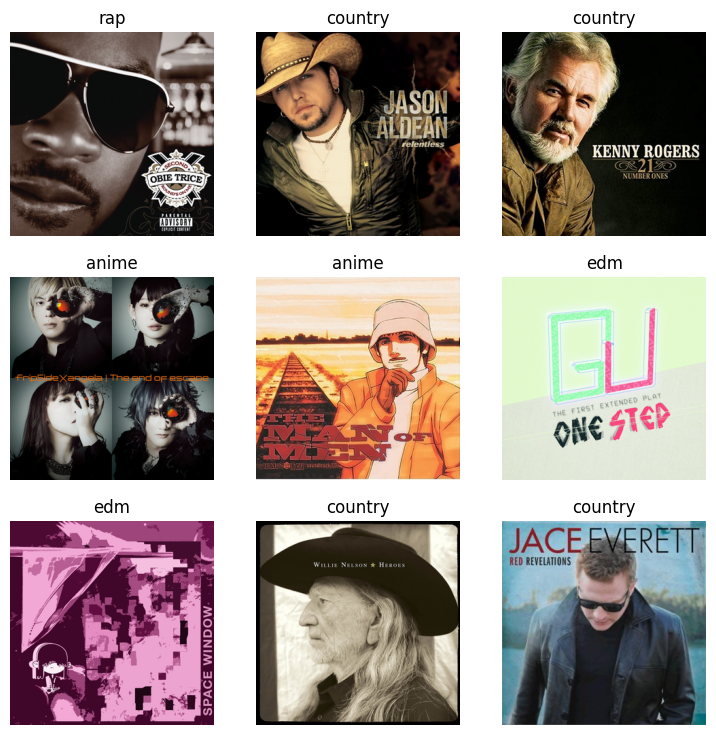

In [35]:
dls.show_batch()

In [36]:
#ResNet101_CV_callback = EarlyStoppingCallback(monitor='valid_loss')

2 **Создать объект модели** \
vision_learner https://docs.fast.ai/vision.learner.html#vision_learner \
а) dls – загрузчик данных \
б) arch – предобученная модель.\
в) cbs	NoneType	None - парамент callback из пункта 4.4 ниже\
г) weights для предобученной модели

In [37]:
learn = vision_learner(dls, models.resnet50, pretrained=True, normalize=True, metrics=accuracy) # loss_func=CrossEntropyLossFlat(), ps=0.25, cbs=TerminateOnNaNCallback() #weights=ResNet50_Weights.IMAGENET1K_V1,

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 102MB/s] 


3 **Выбрать метод для обучения**. \
Варианты:\
 1) learner.fine_tune - управляет значением lr на каждой эпохе. Может размораживать модель для обучения на определенной эпохе.\
 https://docs.fast.ai/callback.schedule.html#learner.fine_tune

 2) learner.fit_one_cycle\
 https://docs.fast.ai/callback.schedule.html#learner.fit_one_cycle


In [38]:
%%time
learn.fine_tune(10, 0.005)

epoch,train_loss,valid_loss,accuracy,time


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,accuracy,time
0,1.825352,1.291716,0.603846,1:11:38


epoch,train_loss,valid_loss,accuracy,time
0,0.884425,0.957287,0.689744,02:10
1,0.479397,1.106175,0.669872,02:09
2,0.448853,1.206767,0.687820,02:10
3,0.304879,1.312556,0.678846,02:09
4,0.175980,1.288896,0.705128,02:09
5,0.091736,1.244226,0.721795,02:09
6,0.050839,1.254299,0.721154,02:09
7,0.027439,1.283200,0.723718,02:10
8,0.016353,1.263960,0.728205,02:09
9,0.009806,1.258260,0.727564,02:09


CPU times: user 8min 55s, sys: 8min 30s, total: 17min 26s
Wall time: 1h 33min 16s


In [47]:
models = {
    "Размер батча": [50, 50, 50, 50, 65, 50, 60],
    "learning rate": [0.001, 0.001, 0.01, 0.01, 0.01, 0.05, 0.005],
    "время выполнения": ["60 min", "26 min", "46 min", "22 min", "22 min", "20 min", "110 min"],
    "Использование TerminateOnNaNCallback()": ["X", "✔", "X", "X", "X", "X", "X"],
    "Использование весов ResNet50_Weights.IMAGENET1K_V1": ["X", "✔", "✔", "X", "X", "X", "X"],
    "Использование normalize=True": ["✔", "✔", "✔", "✔", "✔", "✔", "✔"],
    "Лучший показатель метрики accuracy": [0.723, 0.714, 0.716, 0.739, 0.719, 0.704, 0.727],
    "эпоха лучшего показателя метрики": [19, 5, 5, 5, 5, 5, 10],

}

df = pd.DataFrame(models)
display(df)

,Размер батча,learning rate,время выполнения,Использование TerminateOnNaNCallback(),Использование весов ResNet50_Weights.IMAGENET1K_V1,Использование normalize=True,Лучший показатель метрики accuracy,эпоха лучшего показателя метрики
0,50,0.001,60 min,X,X,✔,0.723,19
1,50,0.001,26 min,✔,✔,✔,0.714,5
2,50,0.010,46 min,X,✔,✔,0.716,5
3,50,0.010,22 min,X,X,✔,0.739,5
4,65,0.010,22 min,X,X,✔,0.719,5
5,50,0.050,20 min,X,X,✔,0.704,5
6,60,0.005,110 min,X,X,✔,0.727,10


**При размере батча выше 65 выходит ошибка (видимо не хватает памяти для обработки)** \

OutOfMemoryError: CUDA out of memory. Tried to allocate 72.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 61.06 MiB is free. Process 15846 has 14.69 GiB memory in use. Of the allocated memory 13.90 GiB is allocated by PyTorch, and 649.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

4 **Проанализировать модель.** \
https://docs.fast.ai/learner.html \

1.
**Recorder.plot_loss**\
https://docs.fast.ai/learner.html#recorder.plot_loss \
график функции потерь\

2.
**ClassificationInterpretation.confusion_matrix**\
https://docs.fast.ai/interpret.html#classificationinterpretation.confusion_matrix \
матрица ошибок\

3.
**Learner.get_preds**\ получить предсказания модели и проанализировать из в skilearn например\
https://docs.fast.ai/learner.html#learner.get_preds\
preds,targs = learn.get_preds(act = torch.sigmoid)\
с показом ошибки with_loss = True.\

4.
**SaveModelCallback** \
чтобы сохранить модель в процессе обучения (callback - типа функция обратного вызова в переводе)\
https://docs.fast.ai/callback.tracker.html#savemodelcallback\
Используется при обучении модели (допустим при заданном колиечстве эпох), и если про процессе прохождении этих эпох функция потерь модели может ухудшаться. callback - автоматически сохранит лучшую модель, чтобы не приходилось потом сокращать количество эпох и запускать модель заново.\

5.
**EarlyStoppingCallback** \
функция ранней остановки. Позволит остановить обучение, если в течении заданного количества эпох результат модели не улучшается.\
https://docs.fast.ai/callback.tracker.html#earlystoppingcallback\


Визуализация результатов модели нейросети Resnet50:

In [8]:
interp50 = ClassificationInterpretation.from_learner(learn)

NameError: name 'learn' is not defined

In [ ]:
interp50.plot_confusion_matrix()

Матрица ошибок показывает на каких жанрах модель ошибается больше всего. В нашем случае _____.

In [ ]:
preds, target, losses = learn.get_preds(with_loss=True)

In [ ]:
learn.show_results()

In [ ]:
learn.recorder.plot_sched()

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

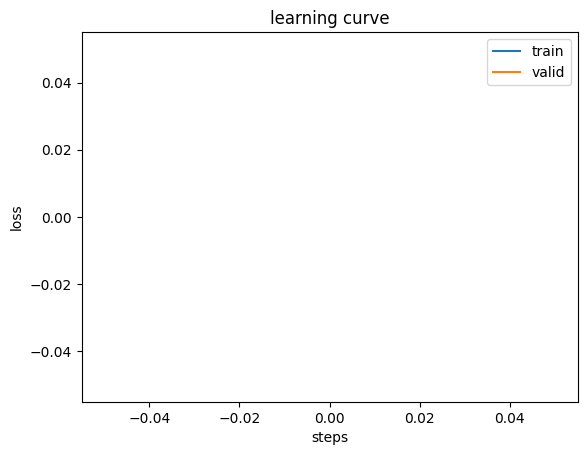

In [45]:
learn.recorder.plot_loss()

Я не могу уже визуализировать ошибки модели, у меня в колабе постоянно подыхает gpu， ждать каждый раз сутки. Уже третий день пытаюсь прогнать все модели и код до конца. Надеюсь основную работу видно, работу итоговой модели тоже.\

Из вопросов:\
1) Не могу определить почему 1 часть проекта baseline faiss показывает такие низкие результаты, вроде у других в чате были около 0,7? Эмбендинги извлекла, faiss настроила, есть ли мысли в чем может быть дело?\

2) Как еще можно улучшить работу нейросети? Экспериментировала с параметрами в таблице выше, но результат не сильно меняется.